In [16]:
%pip install diffusers transformers

# UNSPLASH + SB + SAM Setup

In [44]:
unsplash_image = "https://images.unsplash.com/photo-1727884747982-4532ed1cb541?q=80&w=800&auto=format&fit=crop"
device = "cuda"

## SAM

Inspired by:
- https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- https://colab.research.google.com/drive/1B7L4cork9UFTtIB02EntjiZRLYuqJS2b#scrollTo=LtZghyHoJabf

In [71]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision
from diffusers.utils import load_image, make_image_grid
from transformers import SamModel, SamProcessor
from PIL import Image

In [57]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
  if len(masks.shape) == 4:
    masks = masks.squeeze()
  if scores.shape[0] == 1:
    scores = scores.squeeze()

  nb_predictions = scores.shape[-1]
  fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

  for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.cpu().detach()
    axes[i].imshow(np.array(raw_image))
    show_mask(mask, axes[i])
    axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
    axes[i].axis("off")
  plt.show()

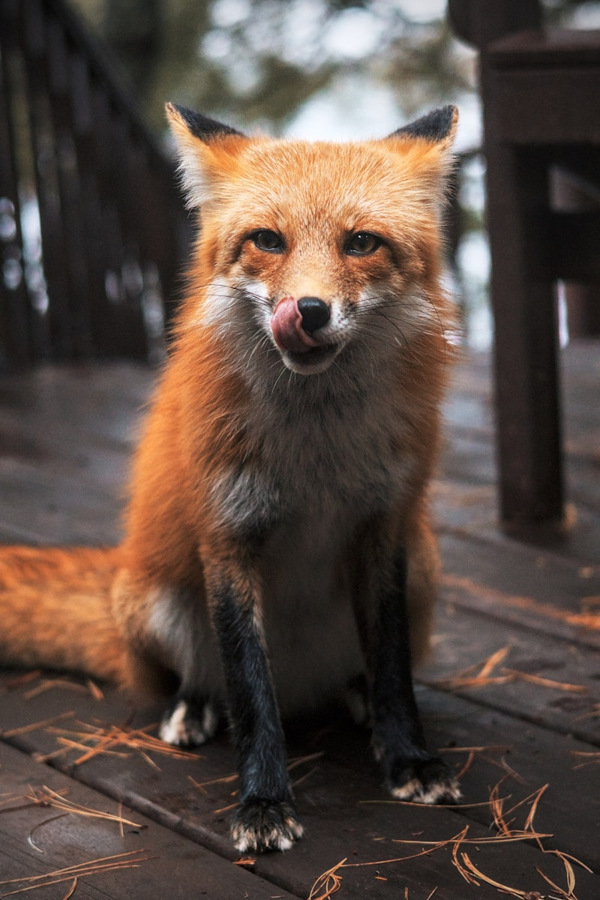

In [80]:
image = load_image(unsplash_image)
aspect_ratio = image.height / image.width

w = 600
h = int(w * aspect_ratio)
image = image.resize((w, h))
image

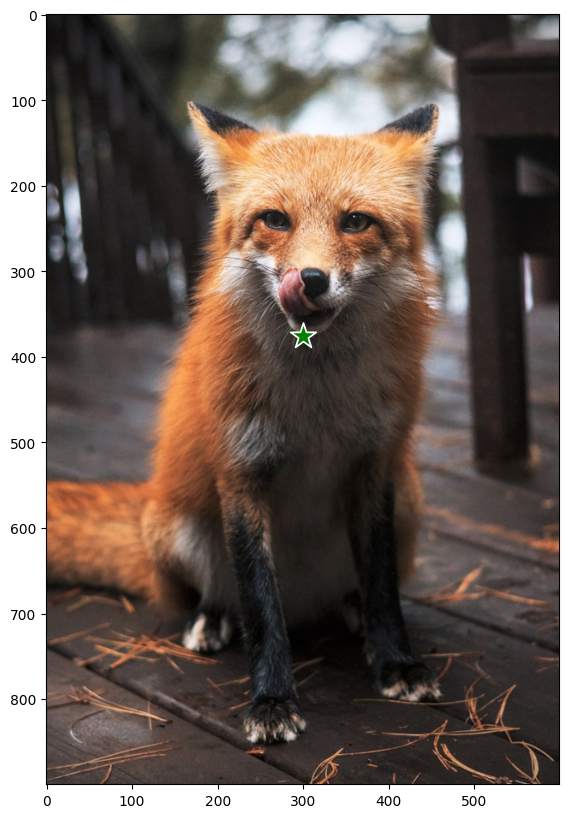

In [82]:
# Setting up a point on the image to indicate to SAM what we want to segment.
input_points = [[[300, 375]]]
show_points_on_image(image, input_points[0])


In [83]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [85]:
inputs = sam_processor(image, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

In [86]:
inputs = sam_processor(image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

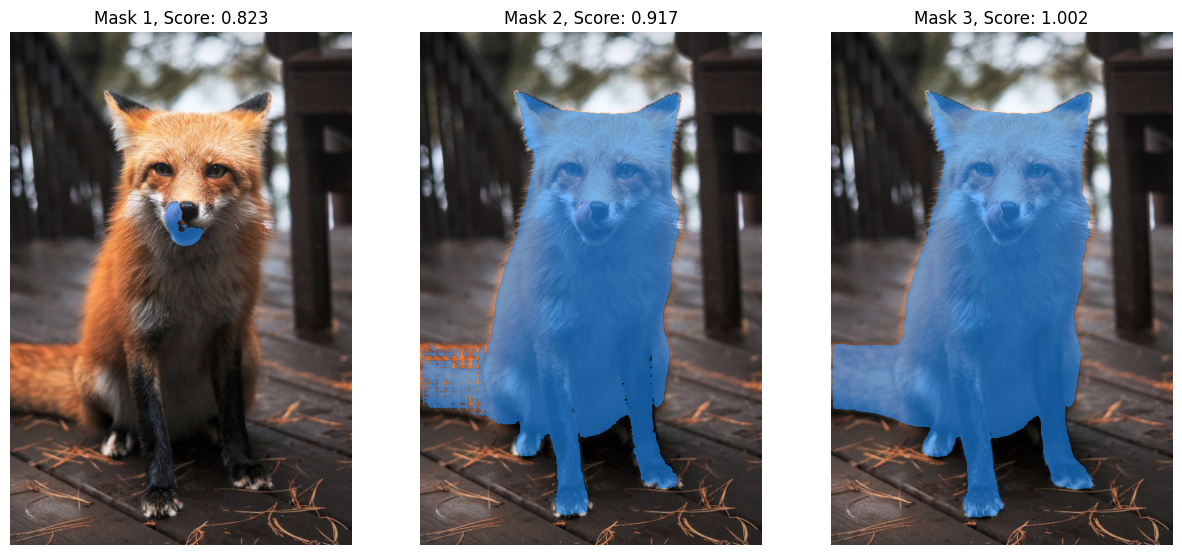

In [88]:
show_masks_on_image(image, masks[0], scores)

In [ ]:
mask = torch.mean(masks[0][0].float(), dim=0)
binary_mask = (mask.cpu().numpy() * 255).astype(np.uint8)
mask_image = Image.fromarray(binary_mask)
mask_image = mask_image.resize(image.size)

mask_image